## Total Variation

Author : Olivier Leblanc
Date : 06/06/2022

Code description :
Consider the inverse problem of a noisy linear forward model: y=Ax+n.
Calibrate the choice of the regularization parameters using PyProximal.


In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import types
import numpy as np
import pylops
import pyproximal

Define some Util functions

In [2]:
snr = lambda ref, rec : 20*np.log10(np.linalg.norm(ref)/np.linalg.norm(rec-ref))

def eval_nu(init, A, A_star=None, nb_iter = 10):
    """Estimate the square norm of the operator B (i.e. ||B||^2) thanks to the power method.
        Useful to bound the norm of B, i.e. give |B(x)|^2 \leq \nu |x|^2`.
    """ 
    if isinstance(A, types.FunctionType):
        if (A_star is None):
            raise ValueError("A_star must be provided")
        A_op = A
        At_op = A_star
    else:
        if (A_star is None):
            A_star = A.T
        A_op = lambda x: A@x
        At_op = lambda y: A_star@y

    u = init
    for k in range(nb_iter):
        u = u/np.linalg.norm(u) # Normalize current matrix
        u = At_op(A_op(u))            
    return np.linalg.norm(u)

def subplot_axs(fig,ny,nx):
    """Create all axes for a subplot.

    Args:
        fig (figure)           : the figure onto creating the axes.
        ny (int)               : number of subplots along y-axis.
        nx (int)               : number of subplots along x-axis.

    Returns:
        axs (array of axes) : all the created axes.

    """
    axs=[None]*nx*ny
    wx = (1/(1.5*nx))
    wy = (1/(1.5*ny))

    for j in np.arange(ny):
        for i in np.arange(nx):
            axs[j*nx+i] = fig.add_axes([i/nx, 1-j/ny, wx, wy])

    if (ny>1 and nx>1):
        axs=np.asarray(axs).reshape(ny,nx) # create 2D axis if necessary

    return axs

def show_objective(ax, objective, labels, log_scale=True, linewidth=1.2):
    """Subplot the objective vs iteration in axis `ax`.

    Args:
        ax (axis) : axis onto plot.
        objective (float array) : objective function values vs iteration
        labels (list) : list of labels for each dimension in `objective`.
        log_scale (bool) : whether to plot in log scale.
        line_width (float) : line width.

    Returns:
        /

    """

    objective=np.real(np.array(objective))
    nplots = objective.ndim

    if nplots==1:
        objective = objective[..., np.newaxis]
    else:
        ax.plot(np.sum(objective, axis=1), label='Global objective')

    if (labels is not None and len(labels)==nplots):
        for i in range(nplots):
            ax.plot(objective[:, i], label=labels[i])
    else:
        for i in range(nplots):
            ax.plot(objective[:, i], label='Objective'+str(i))

    for line in ax.lines:
        line.set_linewidth(linewidth)
    ax.set_ylim(1e-30)
    ax.grid(True)
    ax.set_title('Convergence')
    ax.legend()
    ax.set_xlabel('Iteration number')
    ax.set_ylabel('Objective function value')
    if (log_scale):
        ax.set_yscale('log')
    

def show_rec1D(x, xhat, objective=None, log_scale=True, labels=None, show_Fourier=False, linewidth=1.2):
    """Subplot GT x, reconstruction xhat, and eventually the objective vs iteration and Fourier transforms.
       Also print the SNR of reconstruction.

    Args:
        x (1D array)            : Ground truth  
        xhat (1D array)         : Reconstruction of X 
        objective (float array) : objective function values vs iteration
        show_Fourier (bool)     : if True, plot Fourier transforms

    Returns:
        /

    """
    fig=plt.figure(figsize=(12,4))

    if (objective is None):
        axs=subplot_axs(fig, 1,1)

    else:
        objective=np.real(np.array(objective))
        nplots = objective.ndim
        axs = [fig.add_subplot(1, 2, i+1) for i in range(2)]
        show_objective(axs[1], objective=objective, labels=labels, log_scale=log_scale, linewidth=linewidth)


    axs[0].plot(x, 'o', label='Original')
    axs[0].plot(xhat, 'r')
    axs[0].plot(xhat, 'xr', label='Reconstructed')
    axs[0].grid(True)
    axs[0].set_title('Achieved reconstruction')
    axs[0].legend(numpoints=1)
    axs[0].set_xlabel('Signal dimension number')
    axs[0].set_ylabel('Signal value')
    plt.show()

    if (show_Fourier):
        "Compare reconstructions in Fourier domain"
        fig=plt.figure(figsize=(8,3))
        axs = subplot_axs(fig, 1,2)
        axs[0].plot(np.abs(np.fft.fftshift(np.fft.fft2(x))))
        axs[1].plot(np.abs(np.fft.fftshift(np.fft.fft2(xhat))))
        axs[0].set_title('Ground truth FFT')
        axs[1].set_title('Reconstruction FFT')
        plt.show()

    print('SNR: {:.2f} dB'.format(snr(x, xhat)) )

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/var/folders/k2/5r6ztqx10jscz2r52gj5ry2c0000gn/T/ipykernel_74727/4007404095.py:5: SyntaxWarning: invalid escape sequence '\l'
  Useful to bound the norm of B, i.e. give |B(x)|^2 \leq \nu |x|^2`.


$
    \boldsymbol y = \boldsymbol{Ax} 
$

In [3]:
"Set the parameters of the problem"
np.random.seed(0)
N = 500
M = 100
maxit=500
maxit_prox_TV = 80
rtol=1e-8

x = np.zeros(N)
n_piece = 4
randvals = np.random.randint(30, size=n_piece) 
cuts = np.sort((np.random.rand(n_piece-1)*N).astype(int))
x[:cuts[0]] = randvals[0]
x[cuts[-1]:] = randvals[-1]
for i in range(n_piece-2):
    x[cuts[i]:cuts[i+1]] = randvals[i+1]

Lagrangian formulation

$
    \boldsymbol x^* = \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \boldsymbol u \rVert_{\text{TV}}
$

Using Forward-Backward, the iterates go like

$
    \boldsymbol x^{(k+1)} = \text{prox}_{\gamma \lambda \lVert \cdot \rVert_{\text{TV}}} \left( \boldsymbol x^{(k)} - \gamma \nabla f(\boldsymbol x^{(k)}) \right)
$

with converge rate in $\mathcal O(1/k)$ if $\gamma<2/L$ where $L$ is the Lipschitz constant of $\nabla f$, i.e. 
$
    \lvert \nabla f(x)-\nabla f(y) \rvert \le L\lvert x-y \rvert.
$

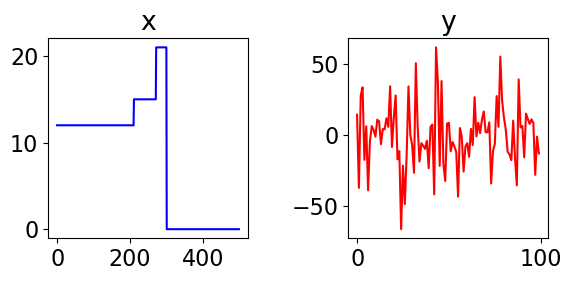

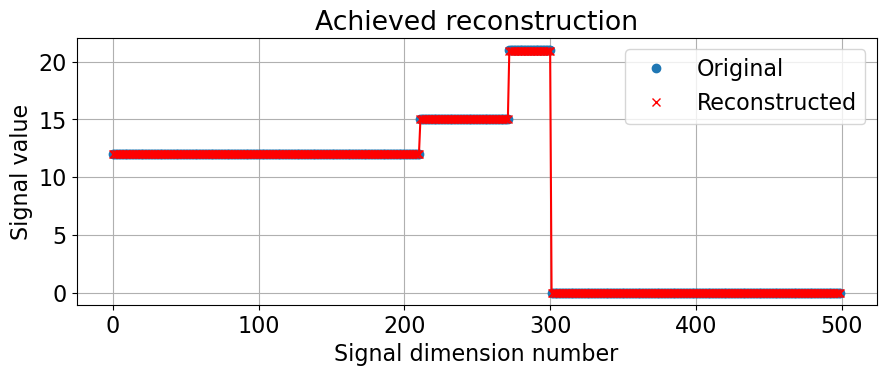

SNR: 60.50 dB


In [4]:
A = np.random.randn(M, N)/np.sqrt(M)
y = A @ x 

fig=plt.figure(figsize=(6,3))
axs = subplot_axs(fig, 1,2)
axs[0].plot(x, 'b-')
axs[1].plot(y, 'r-')
axs[0].set_title('x')
axs[1].set_title('y')
plt.show()

A_op = pylops.MatrixMult(A)

nu = eval_nu(np.random.randn(N), A_op, A_op.T, nb_iter=50)*1.01
adjoint = A_op.T @ y

# TV norm regularization
TV = pyproximal.TV(dims=(N,), niter=maxit_prox_TV, rtol=1e-9, sigma=0.5)
# L2 data fidelity term
l2 = pyproximal.L2(Op=A_op, b=y)
# Solve
x0 = adjoint

# Unused slow version
# xhat = pyproximal.optimization.primal.ProximalGradient( \
#     proxf=l2, proxg=TV, x0=x0, tau=1/nu, epsg=0.5e2, niter=maxit, show=False)

xhat = pyproximal.optimization.primal.ProximalGradient(\
                                proxf=l2, proxg=TV, x0=x0, tau=1/nu, 
                                epsg=1., niter=maxit, acceleration='fista', show=False)
#xhat = pyproximal.optimization.primal.AcceleratedProximalGradient(\
#                                proxf=l2, proxg=TV, x0=x0, tau=1/nu, 
#                                epsg=1., niter=maxit, acceleration='fista', show=False)


show_rec1D(x, xhat, objective=None, log_scale=True, linewidth=1.2)

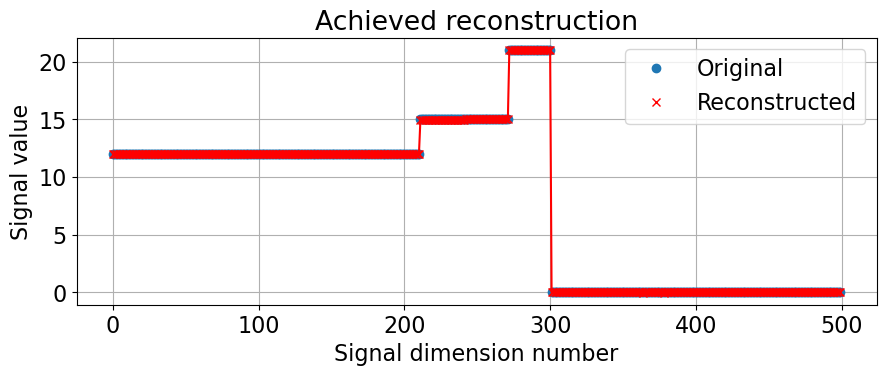

SNR: 59.75 dB


In [5]:
"Positivity constrain"
pos = pyproximal.Box(lower=0)

xhat2 = pyproximal.optimization.primal.GeneralizedProximalGradient(\
                                proxfs=[l2], proxgs=[TV, pos], x0=x0, tau=1/nu, 
                                epsg=1, niter=maxit, acceleration='fista', show=False)

show_rec1D(x, xhat2, objective=None, log_scale=True, linewidth=1.2)

### Adapting $\lambda$ between meta-iterations

The idea is that as $\boldsymbol y = \boldsymbol{Ax} + \boldsymbol n$ with $\epsilon \approx \lVert \boldsymbol n \rVert$, we should expect from the error at the end of a meta-iteration to tend towards $\epsilon$. If the error is too big, we can have $\underbrace{\lVert \boldsymbol{Ax} - \boldsymbol y\rVert}_{\epsilon^{(k)}} \gg \epsilon$. In this case, one must decrease the weight of the prior term $\lambda$. This parameter is adapted as
$
    \lambda^{(k+1)} = \lambda^{(k)} \frac{\epsilon}{\epsilon^{(k)}}
$

This does not seem implemented as described...

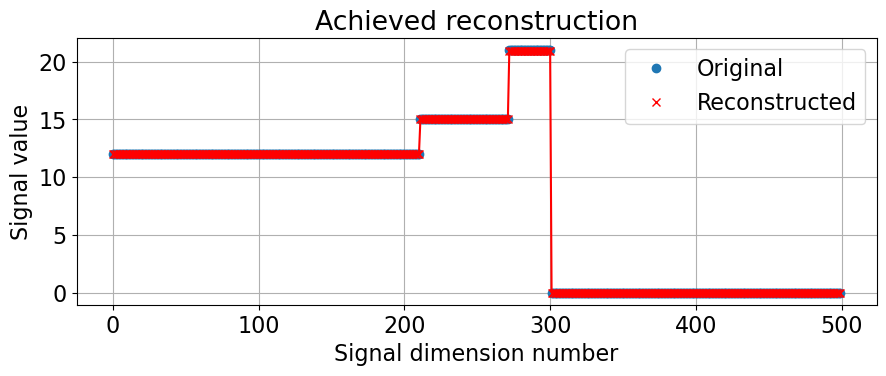

SNR: 60.40 dB


In [6]:
SNR_target = 100
epsilon = np.linalg.norm(x)*10**(-SNR_target/20)

# TV norm regularization
TV = pyproximal.TV(dims=(N,), niter=maxit_prox_TV, rtol=1e-9, sigma=0.5)
# L2 data fidelity term
l2 = pyproximal.L2(Op=A_op, b=y)
# Solve
x0 = adjoint

# if tau=None, backtracking line search is used
xhat3 = pyproximal.optimization.primal.ProximalGradient(\
                                proxf=l2, proxg=TV, x0=x0, tau=None, 
                                epsg=1., niter=maxit, acceleration='fista', show=False)

show_rec1D(x, xhat3, objective=None, log_scale=True, linewidth=1.2)

Linearized ADMM

\begin{align*}
    \boldsymbol x^* &= \argmin_{\boldsymbol u}~f(\boldsymbol u) + g(\boldsymbol{Au}) \\
    &= \argmin_{\boldsymbol u}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Au} \rVert^2 + \lambda \lVert \nabla \boldsymbol u \rVert_1
\end{align*}

The Linearized-ADMM algorithm can be expressed by the following recursion:

$
    \boldsymbol{x}^{(k+1)} = \text{prox}_{\mu f} (\boldsymbol x^{(k)} - \frac{\mu}{\tau} \boldsymbol A^H (\boldsymbol{Ax}^{(k)} - \boldsymbol z^{(k)} + \boldsymbol u^{(k)} ) ) \\
    \boldsymbol z^{(k+1)} = \text{prox}_{\tau g} (\boldsymbol{Ax}^{(k+1)} + \boldsymbol u^{(k)} 
    ) \\
    \boldsymbol u^{(k+1)} = \boldsymbol u^{(k)} + \boldsymbol{Ax}^{(k+1)} - \boldsymbol z^{(k+1)}
$

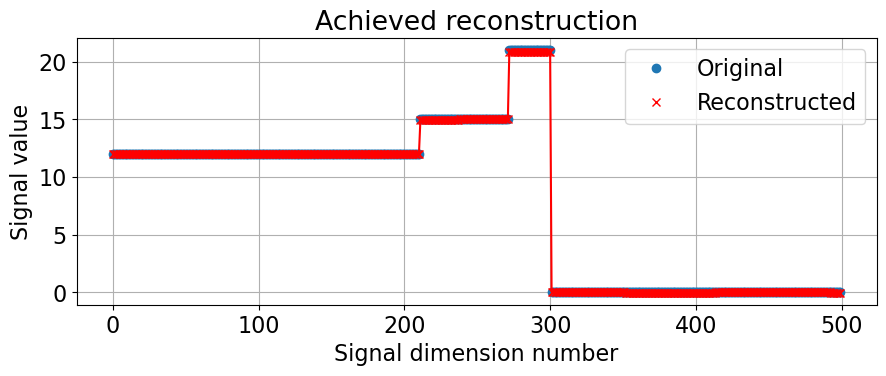

SNR: 48.14 dB


In [7]:
# Gradient operator
Gop = pylops.FirstDerivative(dims=len(x), kind='forward', dtype='float64')
L = 8. # maxeig(Gop^H Gop)

"L2 regularization"
sigma = 2.
l1 = pyproximal.L1(sigma=sigma)

# Solve
tau = 1.
mu = 1. / (tau*L)

xhat4 = pyproximal.optimization.primal.LinearizedADMM( \
    proxf=l2, proxg=l1, A=Gop, tau=tau, mu=2/nu, x0=x0, niter=maxit)[0]

show_rec1D(x, xhat4, objective=None, log_scale=True, linewidth=1.2)

TwIST (Two-step Iterative Shrinkage/Threshold)

$
    \boldsymbol x = \argmin_{\boldsymbol x}~\frac{1}{2} \lVert \boldsymbol y - \boldsymbol{Ax} \rVert_2^2 + g(\boldsymbol x)
$

The TwIST algorithm can be expressed by the following recursion:
$
    \boldsymbol x^{(k+1)} = (1-\alpha) \boldsymbol x^{(k-1)} + (\alpha-\beta) \boldsymbol x^{(k)} + \beta \text{prox}_g (\boldsymbol x^{(k)}) + \boldsymbol A^H(\boldsymbol y- \boldsymbol{Ax}^{(k)}),
$

where $\boldsymbol x^{(1)} = \text{prox}_g (\boldsymbol x^{(0)} + \boldsymbol A^H (\boldsymbol y- \boldsymbol{Ax}^{(0)}) ) $

The optimal weighting parameters $\alpha$ and $\beta$ are linked to the smallest and largest eigenvalues of $\boldsymbol A^H \boldsymbol A$ as follows:

$
    \alpha = 1 + \rho^2 \\
    \beta = \frac{2\alpha}{\Lambda_{\text{max}} + \lambda_{\text{min}} }
$

where $\rho = \frac{1-\sqrt k}{1 + \sqrt k}$ with $k = \frac{\lambda_{\text{min}}}{\Lambda_{\text{max}}}$ and $\Lambda_{\text{max}} = \text{max}(1, \lambda_{\text{max}})$.

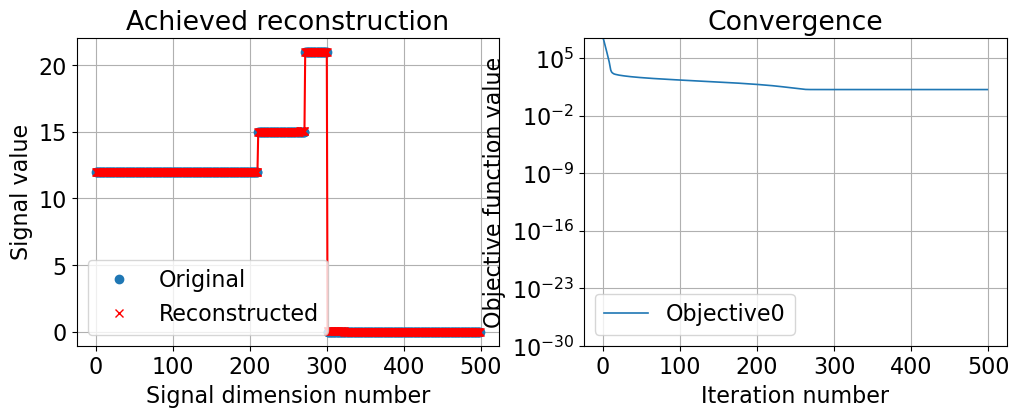

SNR: 59.35 dB


In [8]:
eigs = (A_op.H * A_op).eigs()
eigs = (np.abs(eigs[0]), 5e-1)

xhat5, objective = pyproximal.optimization.primal.TwIST(proxg=TV, A=A_op, b=y, x0=x0, \
                                                       eigs=eigs, niter=maxit, show=False, \
                                                       returncost=True)

show_rec1D(x, xhat5, objective=objective, log_scale=True, linewidth=1.2)                             

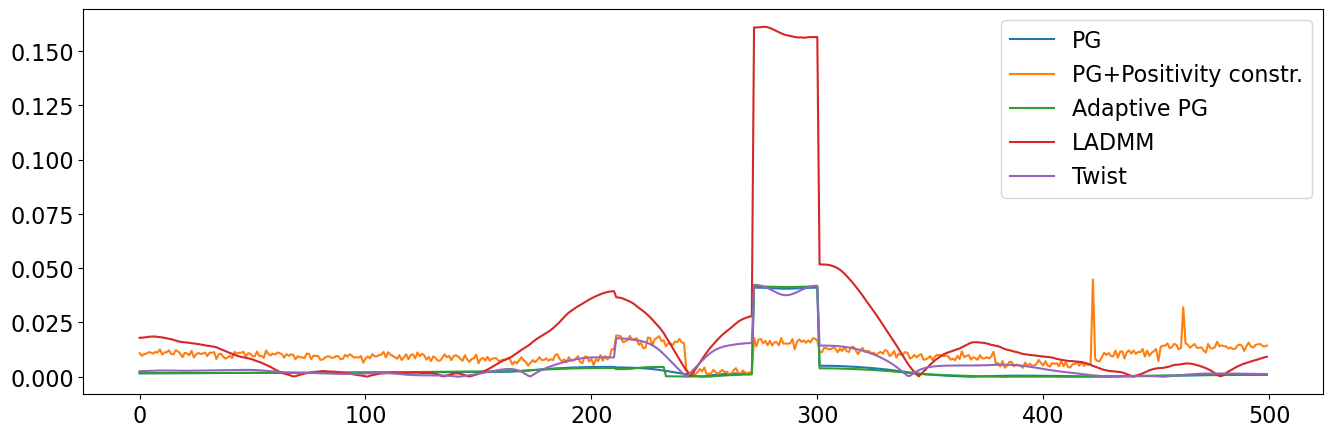

In [9]:
plt.figure(figsize=(16, 5))
plt.plot(np.abs(x-xhat),label='PG')
plt.plot(np.abs(x-xhat2),label='PG+Positivity constr.')
plt.plot(np.abs(x-xhat3),label='Adaptive PG')
plt.plot(np.abs(x-xhat4),label='LADMM')
plt.plot(np.abs(x-xhat5),label='Twist')
plt.legend();